In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import joblib
import multiprocessing as mp

### Processing images to remove checkered background
Basically the code to generate ultramnist-black dataset that has been shared already.

In [2]:
DATA_PATH = "/kaggle/input/ultra-mnist/"
PROCESSED_DATA_PATH = "/kaggle/working/processed_train/"
if not os.path.isdir(PROCESSED_DATA_PATH):
    os.mkdir(PROCESSED_DATA_PATH)

### So we want a black background with digits in white. This is how we do it really fast

In [3]:
def invert_pixels_fast(img):
    img1d = img.reshape(-1)
    pixels, counts = np.unique(img1d, return_counts=True)
    pixel_count = {str(pixel): count for pixel, count in zip(pixels, counts)}
    if "1" in pixel_count:
        invert_pixel = lambda x: 0 if x == 1 else 1
        v_invert_pixel = np.vectorize(invert_pixel)
        # if only white pixels or majority pixels are white
        if "0" not in pixel_count or pixel_count["0"] < pixel_count["1"]:
            # perform vectorized pixel inversion on 1d numpy array
            img_transformed = v_invert_pixel(img1d)
            img = img_transformed.reshape(1000, 1000)    
    return img

In [4]:
# split the 4000 * 4000 binary_image into 16 tiles of 1000 * 1000 and tranform each tile to have a black background
# with white digits
def split_and_transform_img(img):    
    img_tiles = []
    for x in range(4):
        x_start = x * 1000
        x_end = x_start + 1000
        row_img_list = []
        for y in range(4):
            y_start = y * 1000
            y_end = y_start + 1000            
            row_img_list.append(invert_pixels_fast(img[x_start:x_end, y_start:y_end]))
        img_tiles.append(row_img_list)
    return np.array(img_tiles)

In [5]:
# join the transformed tiled images to reconstruct 4000 * 4000 binary image
def join_tiles(tfmd_img_tiles):    
    row_tiles = []
    for i in range(4):
        # join 4 tiles to create a row tile
        row_tiles.append(np.concatenate(tfmd_img_tiles[i, :], axis=1))
    return np.concatenate(row_tiles, axis=0)

In [6]:
def get_pixel_count(img):
    img1d = img.reshape(-1)
    pixels, counts = np.unique(img1d, return_counts=True)
    return {str(pixel): count for pixel, count in zip(pixels, counts)}

In [7]:
def preprocess_train_image(img_name):
    img = cv2.imread(DATA_PATH + "train/"+ img_name)  
    # convert to graycale as original images don't have colors anyway
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # convert all pixels greater than 0 to 1
    binary_img = cv2.threshold(gray_img, 1, 1, cv2.THRESH_BINARY)[1]
    pixel_count = get_pixel_count(binary_img)
    if set(list(pixel_count.keys())) != {"0", "1"}:
        raise AssertionError("There are pixels other than 0 and 1 in the image")
    img_tiles = split_and_transform_img(binary_img)
    tfmd_binary_img = join_tiles(img_tiles)
    plt.imsave(PROCESSED_DATA_PATH + img_name, tfmd_binary_img)
    return img_name

### Let's see how does the original train image looks like

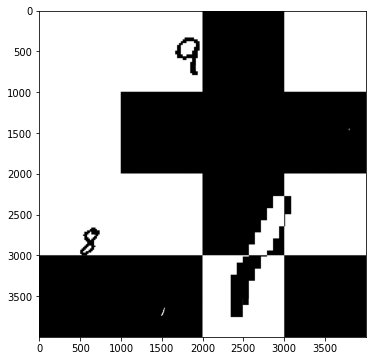

In [8]:
img_to_process = [img for img in os.listdir(DATA_PATH + "train")][:10]
img = cv2.imread(DATA_PATH + "train/" + img_to_process[0])
# matplotlib interprets images in RGB format, but OpenCV uses BGR format
# so to convert the image so that it's properly loaded, convert it before loading
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (8, 6))
plt.imshow(rgb_img)

### Use joblib multiprocessing capabilities to parallelize image processing

In [9]:
from joblib import delayed, Parallel

delayed_funcs = [delayed(preprocess_train_image)(img) for img in img_to_process]
results = Parallel(n_jobs=-1, verbose=5)(delayed_funcs)
print(results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   13.6s remaining:    9.1s


['sbiockeavm.jpeg', 'rugbldpbqk.jpeg', 'keogsdrcyr.jpeg', 'lmanwpwozw.jpeg', 'lczyskpeib.jpeg', 'yprbrpcxmx.jpeg', 'vaakleqjmd.jpeg', 'ptymigoevb.jpeg', 'hfcksnygel.jpeg', 'rhloztvueh.jpeg']


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.1s finished


## Check out how does the processed image looks like

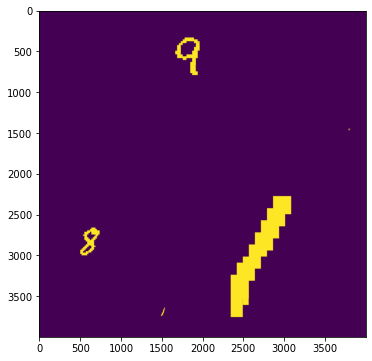

In [10]:
img = cv2.imread(PROCESSED_DATA_PATH + img_to_process[0])
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (8, 6))
plt.imshow(rgb_img)